# Initialize

In [14]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torchinfo import summary

from models.Transformer import ConvViTforEEG
from prepare_data import get_raw_dataloader, get_sub1_dataloader, get_frequency_dataloader, get_time_series_dataloader
from utils.training import best_torch_device, train


In [2]:
# torch.manual_seed(3407)
torch.manual_seed(0)
np.random.seed(0)

In [3]:
%load_ext autoreload
%autoreload 2

## Constants

In [4]:
DEVICE = best_torch_device()
RAW = "raw"
SUB1 = "sub1"
FREQ = "frequency"

## Load Data

In [5]:
train_data = {}
valid_data = {}
test_data = {}

### Raw Data

In [6]:
train_data[RAW], valid_data[RAW], test_data[RAW] = get_raw_dataloader()

In [7]:
print("Training set shape:", train_data[RAW].dataset.X.shape)
print("Validation set shape:", valid_data[RAW].dataset.X.shape)
print("Test set shape:", test_data[RAW].dataset.X.shape)

Training set shape: (1777, 22, 1000)
Validation set shape: (338, 22, 1000)
Test set shape: (443, 22, 1000)


### Sub1 Data

In [8]:
train_data[SUB1], valid_data[SUB1], test_data[SUB1] = get_sub1_dataloader()

In [9]:
print("Training set shape:", train_data[SUB1].dataset.X.shape)
print("Validation set shape:", valid_data[SUB1].dataset.X.shape)
print("Test set shape:", test_data[SUB1].dataset.X.shape)

Training set shape: (199, 22, 1000)
Validation set shape: (38, 22, 1000)
Test set shape: (50, 22, 1000)


### Frequency Data

In [10]:
train_data[FREQ], valid_data[FREQ], test_data[FREQ] = get_frequency_dataloader()

In [11]:
print("Training set shape:", train_data[FREQ].dataset.X.shape)
print("Validation set shape:", valid_data[FREQ].dataset.X.shape)
print("Test set shape:", test_data[FREQ].dataset.X.shape)

Training set shape: (1777, 22, 1000)
Validation set shape: (338, 22, 1000)
Test set shape: (443, 22, 1000)


# Model

In [71]:
from models.Transformer import ConvViTforEEG

test_model = ConvViTforEEG(input_dim=(22, 750),
                      out_dim=4,
                      hidden_dims=64,
                      num_heads=8,
                      ff_dim=64,
                      dropout=0.5,
                      num_layers=1,
                      device=DEVICE).to(DEVICE)
test_model.forward(torch.rand(2, 22, 750))
summary(test_model, input_size=(1, 22, 750), device=DEVICE)

Layer (type:depth-idx)                        Output Shape              Param #
ConvViTforEEG                                 [1, 4]                    6,144
├─Sequential: 1-1                             [1, 40, 1, 187]           --
│    └─Conv2d: 2-1                            [1, 20, 22, 751]          1,300
│    └─BatchNorm2d: 2-2                       [1, 20, 22, 751]          40
│    └─ELU: 2-3                               [1, 20, 22, 751]          --
│    └─Conv2d: 2-4                            [1, 40, 1, 751]           1,800
│    └─BatchNorm2d: 2-5                       [1, 40, 1, 751]           80
│    └─ELU: 2-6                               [1, 40, 1, 751]           --
│    └─AvgPool2d: 2-7                         [1, 40, 1, 187]           --
│    └─Dropout: 2-8                           [1, 40, 1, 187]           --
├─Linear: 1-2                                 [1, 94, 64]               5,184
├─TransformerEncoder: 1-3                     [1, 95, 64]               --
│    └─M

# Training

## Raw Data
Train on raw data, evaluate on raw data

In [72]:
raw_model = ConvViTforEEG(input_dim=(22, 1000),
                      out_dim=4,
                      hidden_dims=64,
                      num_heads=8,
                      ff_dim=64,
                      dropout=0.3,
                      num_layers=1,
                      device=DEVICE).to(DEVICE)

optimizer = torch.optim.Adam(raw_model.parameters(), lr=0.001, weight_decay=1e-03)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=5, verbose=True)

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=raw_model,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_func=nn.CrossEntropyLoss(),
    train_data=train_data[RAW],
    val_data=valid_data[RAW],
    early_stopping_patience=30,
    cp_path="models/cnn_trans",
    cp_filename="raw.pt",
    n_epochs=200,
    show_progress_bar=False,
)

Using device: mps
[Epoch 0] val_acc=0.269231 train_acc=0.252673 val_loss=0.024525 train_loss=0.021917
Validation loss decreased (inf --> 0.024525).  Saving model ...
[Epoch 1] val_acc=0.272189 train_acc=0.288126 val_loss=0.024530 train_loss=0.021755
EarlyStopping counter: 1 out of 30
[Epoch 2] val_acc=0.263314 train_acc=0.306134 val_loss=0.024458 train_loss=0.021591
Validation loss decreased (0.024525 --> 0.024458).  Saving model ...
[Epoch 3] val_acc=0.322485 train_acc=0.325267 val_loss=0.024182 train_loss=0.021536
Validation loss decreased (0.024458 --> 0.024182).  Saving model ...
[Epoch 4] val_acc=0.363905 train_acc=0.353405 val_loss=0.023625 train_loss=0.021320
Validation loss decreased (0.024182 --> 0.023625).  Saving model ...
[Epoch 5] val_acc=0.390533 train_acc=0.400675 val_loss=0.023148 train_loss=0.020914
Validation loss decreased (0.023625 --> 0.023148).  Saving model ...
[Epoch 6] val_acc=0.434911 train_acc=0.442319 val_loss=0.022743 train_loss=0.020478
Validation loss dec

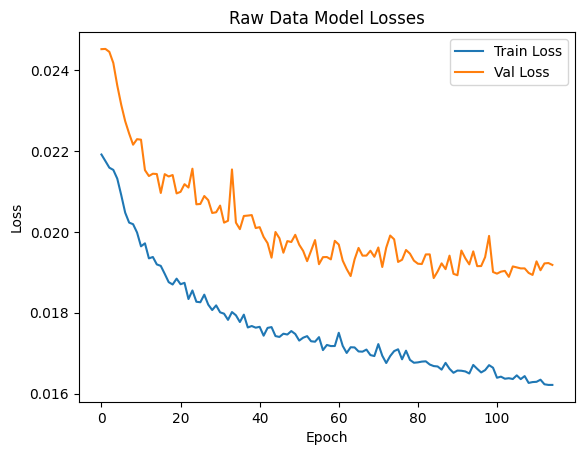

In [73]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Raw Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

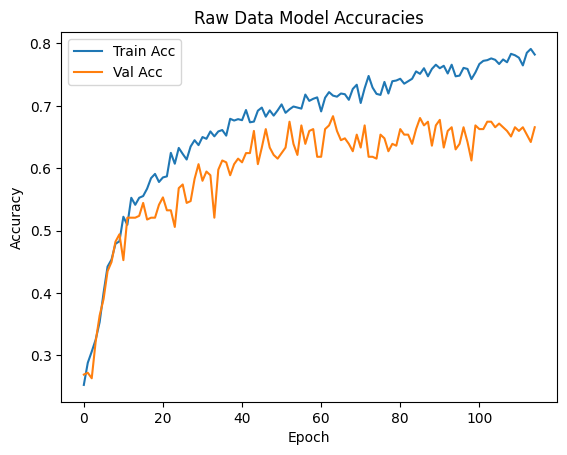

In [74]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Raw Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [75]:
# Load best model and test
raw_model = torch.load("models/cnn_trans/raw.pt")
raw_model.to(DEVICE)
raw_model.eval()

ConvViTforEEG(
  (conv): Sequential(
    (0): Conv2d(1, 20, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Conv2d(20, 40, kernel_size=(22, 1), stride=(1, 1), groups=10)
    (4): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ELU(alpha=1.0)
    (6): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (7): Dropout(p=0.3, inplace=False)
  )
  (lin_emb): Linear(in_features=80, out_features=64, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=64, o

In [76]:
# Evaluate on raw data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[RAW]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = raw_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[RAW].dataset)
print("Train on raw data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on raw data, evaluate on raw data
Test Acc: 0.6501


In [77]:
# Evaluate on sub1 data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[SUB1]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = raw_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[SUB1].dataset)
print("Train on raw data, evaluate on sub1 data")
print(f"Test Acc: {test_acc:.4f}")

Train on raw data, evaluate on sub1 data
Test Acc: 0.6200


## Subject 1 Only    

In [93]:
sub1_model = ConvViTforEEG(input_dim=(22, 1000),
                      out_dim=4,
                      hidden_dims=64,
                      num_heads=8,
                      ff_dim=64,
                      dropout=0.5,
                      num_layers=2,
                      device=DEVICE).to(DEVICE)

optimizer = torch.optim.Adam(sub1_model.parameters(), lr=0.001, weight_decay=1e-03)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=sub1_model,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_func=nn.CrossEntropyLoss(),
    train_data=train_data[SUB1],
    val_data=valid_data[SUB1],
    early_stopping_patience=30,
    cp_path="models/cnn_trans",
    cp_filename="sub1.pt",
    n_epochs=300,
    show_progress_bar=False,
)

Using device: mps
[Epoch 0] val_acc=0.210526 train_acc=0.251256 val_loss=0.036659 train_loss=0.028074
Validation loss decreased (inf --> 0.036659).  Saving model ...
[Epoch 1] val_acc=0.315789 train_acc=0.221106 val_loss=0.036415 train_loss=0.028121
Validation loss decreased (0.036659 --> 0.036415).  Saving model ...
[Epoch 2] val_acc=0.315789 train_acc=0.190955 val_loss=0.036301 train_loss=0.028019
Validation loss decreased (0.036415 --> 0.036301).  Saving model ...
[Epoch 3] val_acc=0.315789 train_acc=0.231156 val_loss=0.036288 train_loss=0.027923
Validation loss decreased (0.036301 --> 0.036288).  Saving model ...
[Epoch 4] val_acc=0.315789 train_acc=0.226131 val_loss=0.036285 train_loss=0.027978
Validation loss decreased (0.036288 --> 0.036285).  Saving model ...
[Epoch 5] val_acc=0.368421 train_acc=0.326633 val_loss=0.036377 train_loss=0.027821
EarlyStopping counter: 1 out of 30
[Epoch 6] val_acc=0.342105 train_acc=0.251256 val_loss=0.036378 train_loss=0.027659
EarlyStopping count

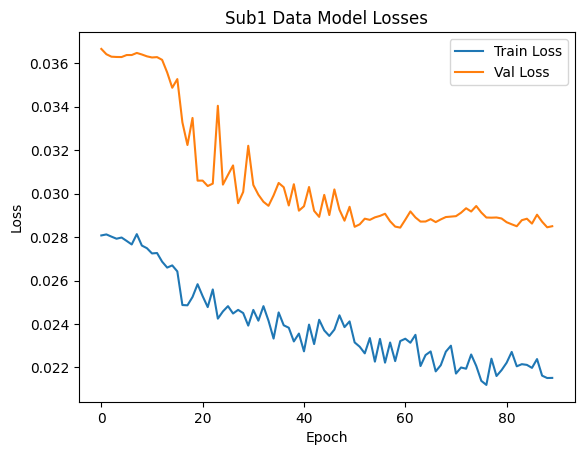

In [94]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Sub1 Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

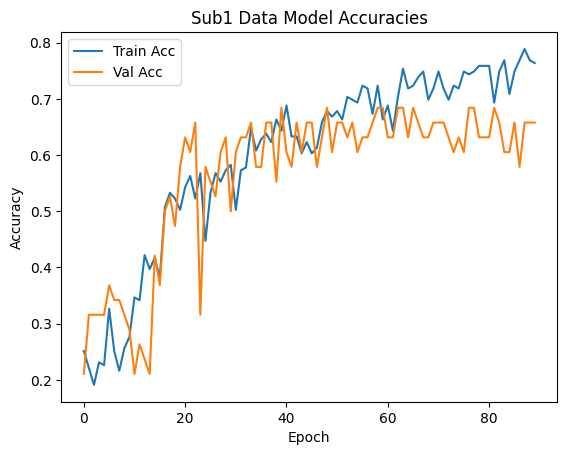

In [95]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Sub1 Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [96]:
# Load best model and test
sub1_model = torch.load("models/cnn_trans/sub1.pt")
sub1_model.to(DEVICE)
sub1_model.eval()

ConvViTforEEG(
  (conv): Sequential(
    (0): Conv2d(1, 40, kernel_size=(1, 32), stride=(1, 1), padding=(0, 16))
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Conv2d(40, 80, kernel_size=(1, 4), stride=(1, 1), padding=(0, 2))
    (4): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ELU(alpha=1.0)
    (6): Conv2d(80, 40, kernel_size=(22, 1), stride=(1, 1), groups=10)
    (7): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ELU(alpha=1.0)
    (9): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (10): Dropout(p=0.3, inplace=False)
  )
  (lin_emb): Linear(in_features=80, out_features=64, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_f

In [97]:
# Evaluate on sub1 data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[SUB1]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = sub1_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[SUB1].dataset)
print("Train on sub1 data, evaluate on sub1 data")
print(f"Test Acc: {test_acc:.4f}")

Train on sub1 data, evaluate on sub1 data
Test Acc: 0.6200


In [98]:
# Evaluate on raw data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[RAW]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = sub1_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[RAW].dataset)
print("Train on sub1 data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on sub1 data, evaluate on raw data
Test Acc: 0.3183


## Frequency Filtering Data

In [100]:
freq_model = ConvViTforEEG(input_dim=(22, 1000),
                      out_dim=4,
                      hidden_dims=64,
                      num_heads=8,
                      ff_dim=64,
                      dropout=0.5,
                      num_layers=2,
                      device=DEVICE).to(DEVICE)

optimizer = torch.optim.Adam(freq_model.parameters(), lr=0.001, weight_decay=1e-03)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=5, verbose=True)

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=freq_model,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_func=nn.CrossEntropyLoss(),
    train_data=train_data[FREQ],
    val_data=valid_data[RAW],
    early_stopping_patience=30,
    cp_path="models/cnn_trans",
    cp_filename="freq.pt",
    n_epochs=200,
    show_progress_bar=False,
)

Using device: mps
[Epoch 0] val_acc=0.242604 train_acc=0.271806 val_loss=0.024571 train_loss=0.021878
Validation loss decreased (inf --> 0.024571).  Saving model ...
[Epoch 1] val_acc=0.248521 train_acc=0.262802 val_loss=0.024606 train_loss=0.021841
EarlyStopping counter: 1 out of 30
[Epoch 2] val_acc=0.281065 train_acc=0.271806 val_loss=0.024480 train_loss=0.021783
Validation loss decreased (0.024571 --> 0.024480).  Saving model ...
[Epoch 3] val_acc=0.289941 train_acc=0.284750 val_loss=0.024418 train_loss=0.021772
Validation loss decreased (0.024480 --> 0.024418).  Saving model ...
[Epoch 4] val_acc=0.301775 train_acc=0.293754 val_loss=0.024374 train_loss=0.021655
Validation loss decreased (0.024418 --> 0.024374).  Saving model ...
[Epoch 5] val_acc=0.304734 train_acc=0.303320 val_loss=0.024389 train_loss=0.021555
EarlyStopping counter: 1 out of 30
[Epoch 6] val_acc=0.340237 train_acc=0.335959 val_loss=0.024037 train_loss=0.021422
Validation loss decreased (0.024374 --> 0.024037).  S

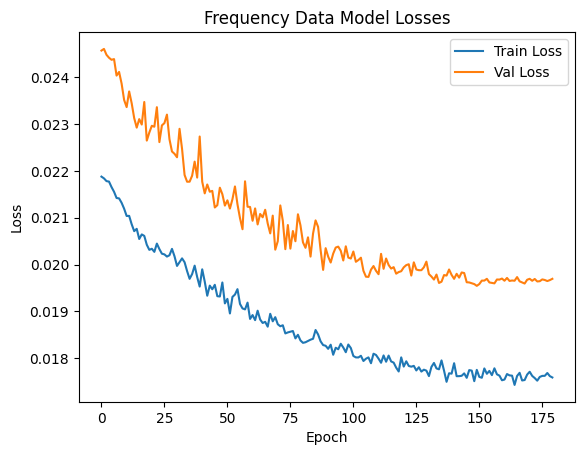

In [101]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Frequency Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

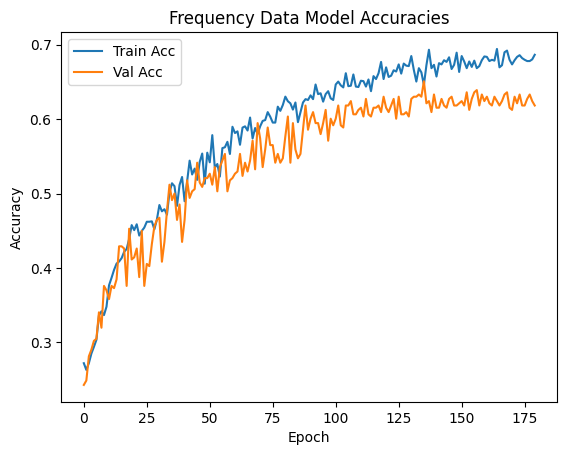

In [102]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Frequency Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [103]:
# Load best model and test
freq_model = torch.load("models/cnn_trans/freq.pt")
freq_model.to(DEVICE)
freq_model.eval()

ConvViTforEEG(
  (conv): Sequential(
    (0): Conv2d(1, 40, kernel_size=(1, 32), stride=(1, 1), padding=(0, 16))
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Conv2d(40, 80, kernel_size=(1, 4), stride=(1, 1), padding=(0, 2))
    (4): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ELU(alpha=1.0)
    (6): Conv2d(80, 40, kernel_size=(22, 1), stride=(1, 1), groups=10)
    (7): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ELU(alpha=1.0)
    (9): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (10): Dropout(p=0.3, inplace=False)
  )
  (lin_emb): Linear(in_features=80, out_features=64, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_f

In [104]:
# Evaluate on frequency data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[RAW]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = freq_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[RAW].dataset)
print("Train on frequency data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on frequency data, evaluate on raw data
Test Acc: 0.6117


## Time Series

In [78]:
time_slots = [50, 100, 150, 200, 250, 500, 750, 1000]

In [79]:
from models.Transformer import ConvViTforEEG

In [80]:
valid_acc = {}
test_acc = {}

for ts in time_slots:
    print(f"Training for time slots: {ts}...")
    
    train_data, valid_data, test_data = get_time_series_dataloader(ts)
    
    time_model = ConvViTforEEG(input_dim=(22, ts),
                      out_dim=4,
                      hidden_dims=64,
                      num_heads=8,
                      ff_dim=64,
                      dropout=0.5,
                      num_layers=2,
                      device=DEVICE).to(DEVICE)
    
    optimizer = torch.optim.Adam(time_model.parameters(), lr=0.001, weight_decay=1e-03)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    
    _ = train(
        model=time_model,
        optimizer=optimizer,
        scheduler=scheduler,
        loss_func=nn.CrossEntropyLoss(),
        train_data=train_data,
        val_data=valid_data,
        early_stopping_patience=20,
        cp_path="models/cnn_trans",
        cp_filename=f"time_{ts}.pt",
        n_epochs=150,
        show_progress_bar=False,
        verbose=False,
    )
    
    # Load best model and test
    time_model = torch.load(f"models/cnn_trans/time_{ts}.pt")
    time_model.to(DEVICE)
    time_model.eval()
    
    # Evaluate validation accuracies
    valid_acc[ts] = 0
    with torch.no_grad():
        for X, y in valid_data:
            X, y = X.to(DEVICE), y.to(DEVICE)
            y_pred = time_model(X)
            valid_acc[ts] += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
    valid_acc[ts] /= len(valid_data.dataset)
    
    # Evaluate test accuracies
    test_acc[ts] = 0
    with torch.no_grad():
        for X, y in test_data:
            X, y = X.to(DEVICE), y.to(DEVICE)
            y_pred = time_model(X)
            test_acc[ts] += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
    test_acc[ts] /= len(test_data.dataset)
    
    print(f"Time slots: {ts}, Valid Acc: {valid_acc[ts]:.4f}, Test Acc: {test_acc[ts]:.4f}")

Training for time slots: 50...
Using device: mps
Time slots: 50, Valid Acc: 0.4467, Test Acc: 0.4424
Training for time slots: 100...
Using device: mps
Time slots: 100, Valid Acc: 0.5710, Test Acc: 0.5508
Training for time slots: 150...
Using device: mps
Time slots: 150, Valid Acc: 0.6095, Test Acc: 0.5598
Training for time slots: 200...
Using device: mps
Time slots: 200, Valid Acc: 0.5976, Test Acc: 0.5824
Training for time slots: 250...
Using device: mps
Time slots: 250, Valid Acc: 0.6302, Test Acc: 0.6456
Training for time slots: 500...
Using device: mps
Time slots: 500, Valid Acc: 0.7012, Test Acc: 0.6749
Training for time slots: 750...
Using device: mps
Time slots: 750, Valid Acc: 0.6716, Test Acc: 0.6321
Training for time slots: 1000...
Using device: mps
Time slots: 1000, Valid Acc: 0.7041, Test Acc: 0.6614


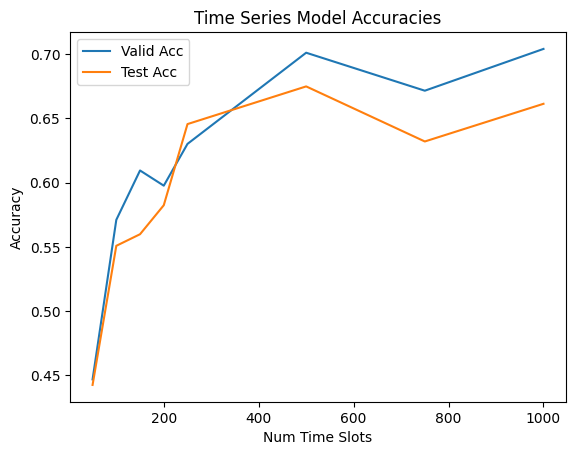

In [81]:
plt.plot(valid_acc.keys(), valid_acc.values(), label="Valid Acc")
plt.plot(test_acc.keys(), test_acc.values(), label="Test Acc")
plt.legend()
plt.title("Time Series Model Accuracies")
plt.xlabel("Num Time Slots")
plt.ylabel("Accuracy")
plt.show()